# MCMC: ANOVA

Main References:
 - [1] https://en.wikipedia.org/wiki/Analysis_of_variance


In [29]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib

import json

# Creating the sample data
Create an array $\mathbf{y}$ of sample data, each sample $y_i$ being drawn from one of two Normal distributions  $N(\mu_1,\sigma)$ or $N(\mu_2,\sigma)$. 

In [46]:
beta = 1.0
K = 2
mu_1_set = -10.0
mu_2_set = 10.0
sigma = 7

N_SAMPLES = 100


y = np.array([])
np.random.seed(0)

phi = np.random.dirichlet([beta,beta])

for i in range(N_SAMPLES):
    
    #the latent variable z is implicit in the function call to np.random.choice
    mu_set = np.random.choice([mu_1_set,mu_2_set],None, True, phi)
    y = np.append(y,np.random.normal(mu_set,sigma))
    
print(y)
print(phi)







[ -5.87829741  19.33481767  18.86282971   6.45886422  13.39018508
  14.05398335   8.72892199  19.87143242 -16.72528228  12.63848882
  -0.94447683   6.03311666   7.66859819  10.33155372  13.96508027
  11.04485564   2.51238832 -13.98662085   2.39939583  -5.52184804
  -3.03002056  -3.53243346   9.02368226 -11.33459185   8.41842241
 -21.58199537  -7.82045548 -15.43214327  -2.16201626 -13.20545694
  12.97775379   9.80420172   7.44965982 -14.75144173 -14.72515282
   9.07051021  11.19700307 -22.07969946   8.5550534   13.41898527
 -16.93632298  -2.87483965  16.47675526   3.66649689   2.90584071
  20.67855067 -10.4939006   14.22911795  16.35263732   5.89923988
  16.81519099  11.45097941  14.24472301  10.01232588   8.31248487
  -9.62658565  15.86403836  -0.43077989  -5.76799406  -2.20140762
  19.03964544  19.1048739    3.25155649  -3.93545174   5.89929372
  12.09140427   9.67976331  10.3492889   -7.47700913  12.85703684
  11.35002604   7.05394626  19.40768094 -15.72754673   5.37227038
   1.73866

### Sample Data Histogram

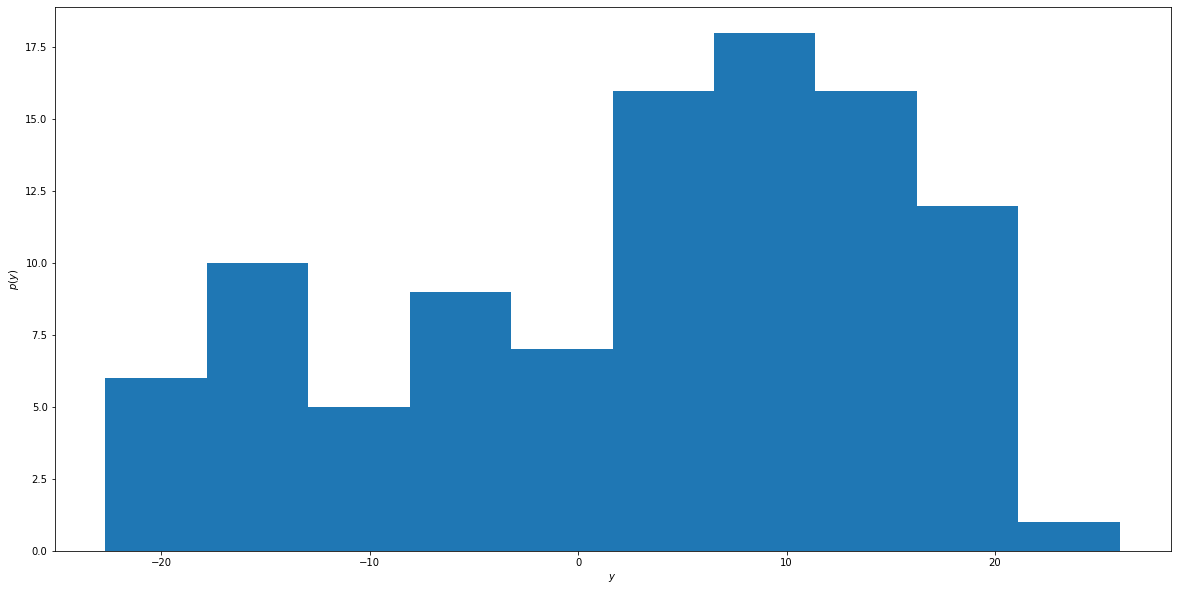

In [47]:
plt.hist(y)
plt.ylabel('$p(y)$')
plt.xlabel('$y$')
plt.show()

# MCMC

In [48]:
observations = y
k=2   # i.e., the number of factor levels

In [49]:
MCMC_model = pm.Model()
with MCMC_model:
    #Parameters
    phi = pm.Dirichlet('phi',a=np.array([1., 1.]), shape=k)
    means = pm.Normal('means', mu=[-1,1], sigma=5, shape=k)
    
    sd = pm.Uniform('sd', lower=0, upper=20)
    
    z = pm.Categorical('z',p=phi, shape=N_SAMPLES)
    
    obs = pm.Normal('obs', 
                    mu=means[z], 
                    sigma=sd, 
                    observed=y)
    

In [50]:
with MCMC_model:  
    step1 = pm.Metropolis(vars=[phi, means])
    step2 = pm.ElemwiseCategorical(vars=[z], values=[0, 1])
    model_trace = pm.sample(N_SAMPLES, step=[step1, step2])
    

/Users/stuarttruax/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [phi]
>ElemwiseCategorical: [z]
>NUTS: [sd]
Sampling 4 chains: 100%|██████████| 2400/2400 [00:02<00:00, 927.49draws/s] 
The acceptance probability does not match the target. It is 0.9063630887579972, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9048411248562401, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9058498297077523, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probabili

# Posterior Distributions

In [51]:

phi_samples= model_trace["phi"][N_SAMPLES:, None]
z_samples = model_trace["z"][N_SAMPLES:, None]

mu_2_samples = model_trace["means"][N_SAMPLES:, 0]
mu_1_samples = model_trace["means"][N_SAMPLES:, 1]

print('Average mu_1:\n',mu_1_samples.mean())
print('Average mu_2:\n',mu_2_samples.mean())

print('Categorical Variabale z:\n', z_samples)



Average mu_1:
 -4.180056419246684
Average mu_2:
 2.9394383824660286
Categorical Variabale z:
 [[[0 1 1 ... 0 0 1]]

 [[0 1 1 ... 0 0 1]]

 [[1 1 1 ... 0 0 1]]

 ...

 [[1 0 0 ... 1 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[1 0 0 ... 1 1 0]]]


Text(0, 0.5, 'Probability Density')

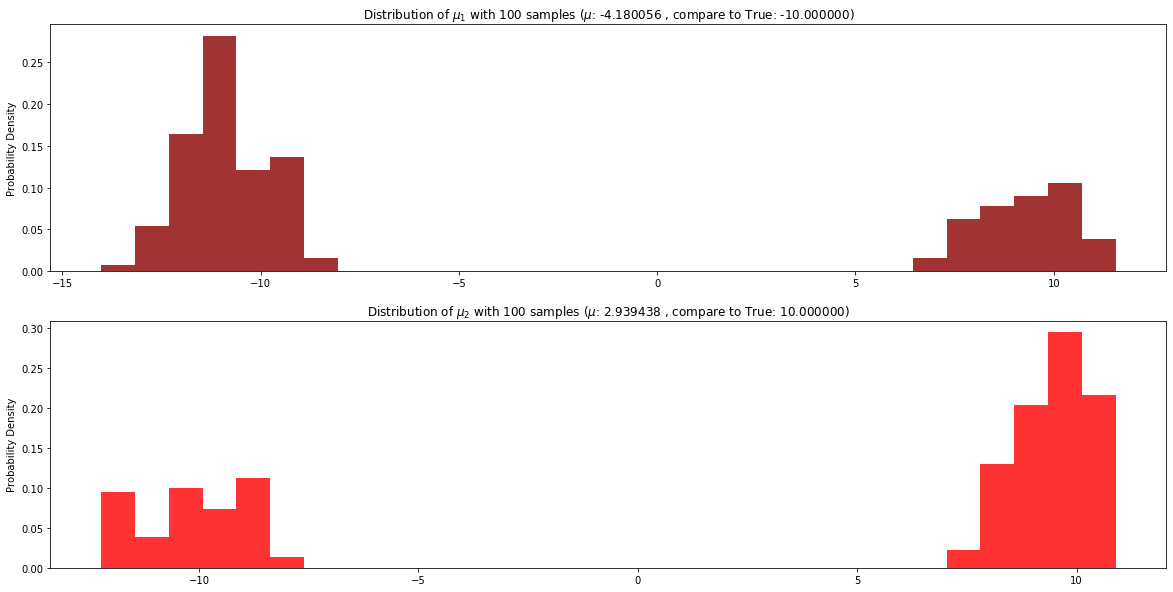

In [52]:
figsize(20, 10)

plt.subplot(211)
plt.title(r"""Distribution of $\mu_1$ with %d samples ($\mu$: %f , compare to True: %f)""" % (N_SAMPLES,mu_1_samples.mean(), mu_1_set))

plt.hist(mu_1_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(212)
plt.title(r"""Distribution of $\mu_2$ with %d samples ($\mu$: %f , compare to True: %f)""" % (N_SAMPLES,mu_2_samples.mean(),mu_2_set))

plt.hist(mu_2_samples, histtype='stepfilled', 
         color = 'red', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')




# Completing the ANOVA: Indicator Variables

An indicator variable $I(\cdot)$ is used to calculate $P(\mu_i < \mu_j)$.  $I(\cdot)$ is defined such that:


$$
I(\text{statement}) = 
     \begin{cases}
       \text{0} &\text{if statement is false}\\
       \text{1} &\text{if statement is true} \\
     \end{cases}
$$

Considering the two above disributions, this probability is calculated as:
$$ P(\mu_1 < \mu_2) = E[I(x_{\mu_1} < x_{\mu_2})] $$

In [53]:
p_hypothesis = np.mean([mu_1_samples < mu_2_samples])
print(p_hypothesis)

0.6666666666666666
